# Emotions

This file imports the text database and adds a feature: emotion.

We use the model from hugginf face: https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion

The model is pretrained. We load it and apply it to each sentence of the texts. 

The feature "emotion" is a list of emotions.

Ex: ['sad', 'sad', 'sad', 'happy', 'sad', 'surprise', 'anger']

## Imports

### Import modules

In [1]:
# swifter provides to faster way to use the function apply for pandas
! pip install swifter
import swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# to track progression of the function 'apply'
from tqdm.auto import tqdm
tqdm.pandas()

### Import model

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from transformers import pipeline
classifier = pipeline("text-classification",
                      model='bhadresh-savani/distilbert-base-uncased-emotion', 
                      return_all_scores=False)


In [73]:
classifier("I've been thinking about death lately.", )[0]

{'label': 'fear', 'score': 0.5137169361114502}

In [74]:
classifier("For a long time, l used to go to bed early.", )[0]

{'label': 'anger', 'score': 0.6550639271736145}

In [75]:
classifier("It is a truth universally acknowledged that a man... ", )[0]

{'label': 'joy', 'score': 0.989703357219696}

In [76]:
classifier("OMG!", )[0]

{'label': 'joy', 'score': 0.5901156663894653}

### Import data

In [4]:
df = pd.read_csv("drive/MyDrive/Final Project/story_data_new_feats.csv")

In [5]:
df.shape

(18248, 85)

In [6]:
# you should not use eval with untrusted input
eval(df.story_sent[2])

['\n \nLin had to figure out things, because objects, issues and all sorts of things gave her mind ideas about the past within heritage.',
 'A moral code was however not modern when she was young, so she had to do wrong kind of acts, just because of it.',
 'And afterwards try to have ways to solve it.',
 'But her shame and guilt was laid down in her personality from fishermen and sailors, as that was her mum´s ancestry.',
 'The compass on the sea might make you roam the waves as they roll into your blood, veins, muscles and sinews.',
 'Her ancestry was of seas and seas have an order and a rule and a law that wash the soil, the sand, the rock.',
 'Waving and weaving getting into you as the compass makes you roll on in a direction where something leads you.',
 'Moral?',
 'You might think that all sailors lack moral, but that is not alltogether true.',
 'To stay poor winter after winter meant that Lin´s family had never been part of the slavetrade.',
 'The poverty that then ran in Lin´s b

We will be using the feature 'story_sent', which corresponds to a list of sentences of the text.

## Apply model

### Example:

In [16]:
print(df['text_str'][0][:1000])


11:59  
	I shoot straight out of bed to an ear piercing alarm right outside my door.  The walls of this room are a dull white.  Every day that passes it seems as though those walls are closing in on me.  The bed feels as though I am sleeping on just springs.  The only other items in this room are a sink and a toilet.  The door, my only release from this hole, is so thick a bullet would not even pierce it.  There is a small window in here, which is more just a tease than anything else, showing me green grass for miles.  I have had to look at that and this depressing room for nine years, only leaving when I have a visitor.  Today though is different, today is the day I die.  This place is hell, this place is death row.  Every single day of my miserable nine years here, which is exactly 3,287 days, I have looked back at what got me here and thought about my life before I was sent here.  Today is no different. 
***
	I pull into the garage parking lot after a hectic day at the office; I ha

In [18]:
classifier(df['text_str'][0][:1000], )[0]

{'label': 'sadness', 'score': 0.9958788156509399}

It seems quite accurate on this example.

### By sentences:

In [10]:
def pipeline_sent(row):
  """
  Applies the model to each sentence of the given text
  Counts the occurences of each label (fear, joy...)
  Assign the counter value to the label corresponding column
  """
  out = []
  for sentence in eval(row['story_sent']):
    try:
      out.append(classifier(sentence, )[0]['label'],)
    except:
      pass
  row['emotion_all'] = out
  for label in set(out):
    row['emotion_' + label] = out.count(label)
  
  return row

We chunk the data set into 80 data sets, and we save each one of them once the code is executed for each.

It should take an hour to apply the function to each data set.

In total, 80 hours.

In [11]:
splits = 80
18000/splits

225.0

In [12]:
chunk_size = int(df.shape[0] / splits-1)
df_subset = dict()
for start in range(0, df.shape[0], chunk_size):
    df_subset[start] = df.iloc[start:start + chunk_size]
fract = list(df_subset.keys())
for i,j in zip(range(1, len(fract)+1), fract):
  df_subset[i] = df_subset.pop(j)

In [102]:
len(df_subset)

81

In [13]:
emotion_cols = ['emotion_all',
       'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love',
       'emotion_sadness', 'emotion_surprise']

In [19]:
df.shape

(18248, 78)

In [121]:
# each sentence
for i tqdm(range(1, 82)):
  # apply function
  
  df_emotion_subset = df_subset[i].swifter.apply(pipeline_sent, axis=1)
    
  # save csv
  df_emotion_subset[emotion_cols].to_csv(f'drive/MyDrive/Final Project/emotion_features/df_emotion_subset_{i}.csv', index=False)

Load all the files

In [107]:
# merge files
# ...

Add to main file

In [ ]:
df = pd.read_csv("drive/MyDrive/Final Project/story_data_new_feats.csv")

In [113]:
df_emotions = pd.read_csv("drive/MyDrive/Final Project/df_emotions.csv")

In [114]:
result = pd.concat([df, df_emotions], axis=1, join='inner')


In [117]:
result.to_csv(f'drive/MyDrive/Final Project/story_data_new_feats.csv', index=False)

### By texts:

If we have by sentence, we do not need by text.

The code takes appeoximately 2 hours (less).

In [ ]:
def pipeline_text(row):
  """
  Applies the model to the given text (first 1000 characters)
  """
  row['emotion'] = classifier(row['text_str'][:1000], )[0]['label']
  
  return row

In [ ]:
# whole text
df = df.progress_apply(pipeline_text, axis=1)

In [ ]:
# # each text with swifter
# %%time
# df = df.swifter.apply(pipeline_text, axis=1)

In [ ]:
df.emotion.unique()

In [ ]:
df.shape

In [ ]:
# One hot encode the emotion
df = pd.get_dummies(df, columns=['emotion'])

In [ ]:
df.shape

## Results

In [ ]:
# with pd.option_context('display.max_rows', 2, 'display.max_columns', None): 
#     display(df.sample(5))

### Exploration for emotions by text

In [7]:
emotions_cols = [col for col in df if col.startswith('emotion')]

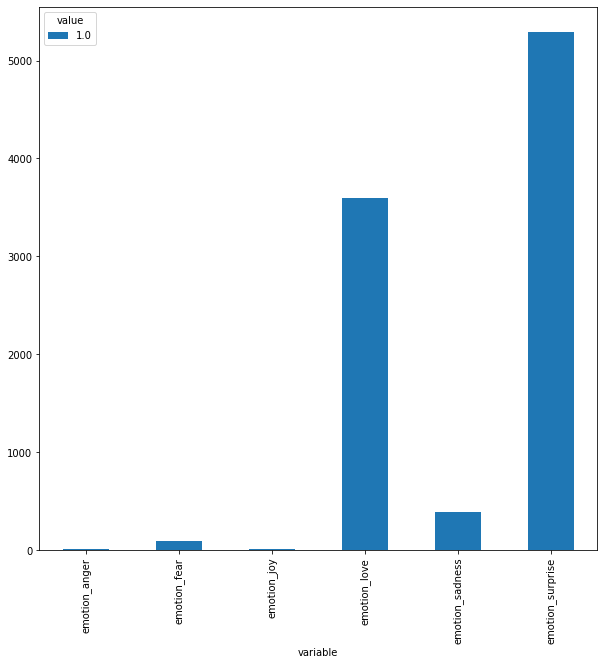

In [8]:
dfm = df[emotions_cols].melt()
dfm = dfm[dfm.value==1]
plot_df = (
    pd.crosstab(dfm['variable'], dfm['value'])
)
plot_df.plot.bar(figsize=(10,10))
# plt.tight_layout()
# plt.show()


In [16]:
emotions_cols.remove('emotion_all')

In [17]:
emotions_cols

['emotion_anger',
 'emotion_fear',
 'emotion_joy',
 'emotion_love',
 'emotion_sadness',
 'emotion_surprise']

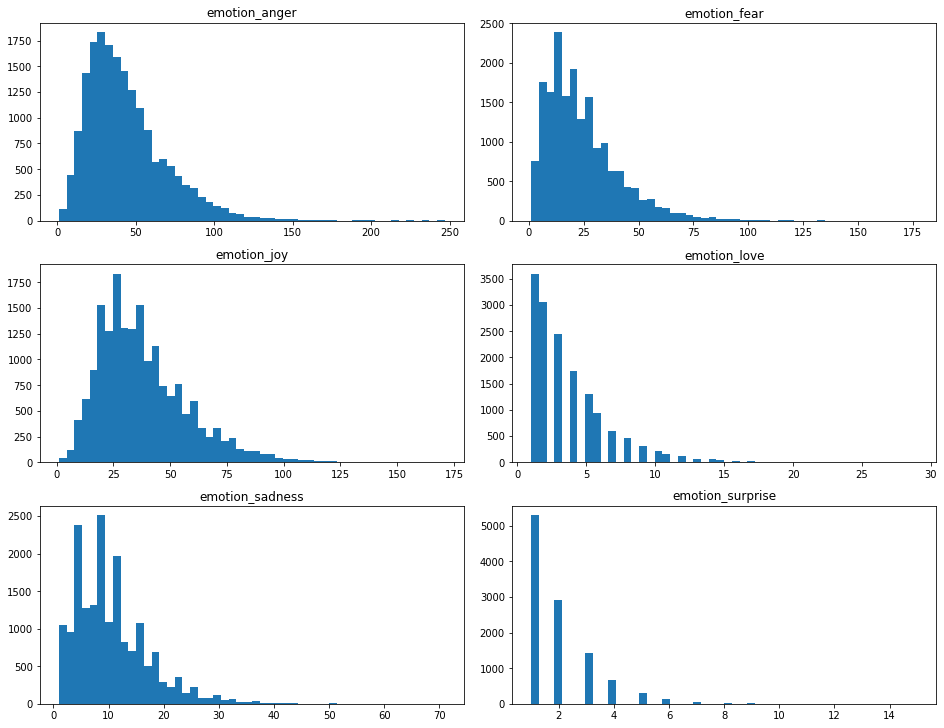

In [18]:
# Distribution of new features
my_j = int(len(emotions_cols)/2)
f,ax=plt.subplots(my_j,2, figsize=(13,10), constrained_layout = True)
feat_iter=iter(emotions_cols)
for i in range(my_j):
    for j in range(2):
      try:
        x = next(feat_iter)
        ax[i,j].hist(df[x], bins=50)
        ax[i,j].set_title(x)
      except StopIteration:
          pass

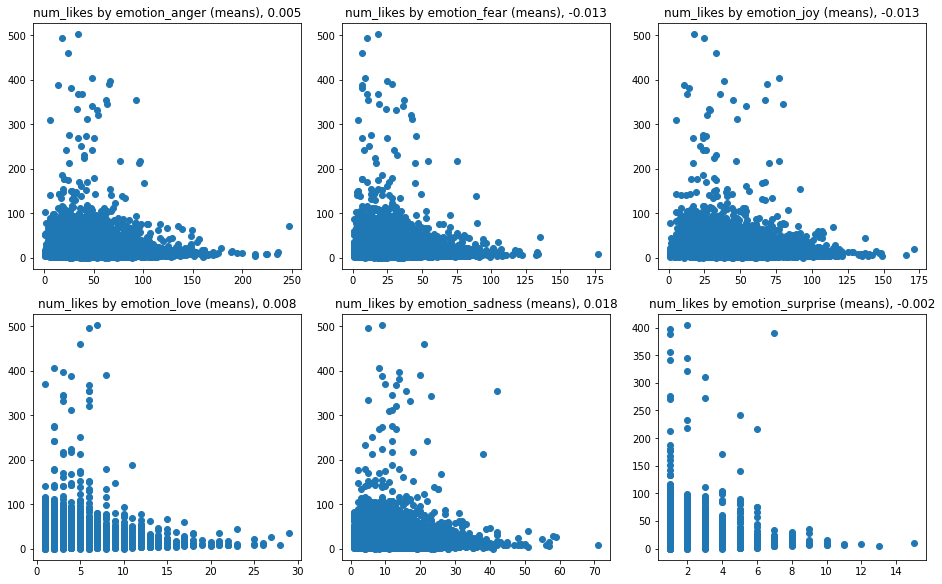

In [24]:
target = 'num_likes'
my_j = int(len(emotions_cols)/3)

f,ax=plt.subplots(my_j,
                  3, 
                  figsize=(13,8), 
                  constrained_layout = True)
feat_iter=iter(emotions_cols)

for i in range(my_j):
    for j in range(3):
      try:
        x = next(feat_iter)
        ax[i,j].scatter(df[x], df[target])
        #df.groupby(x)[target].mean().sort_values().plot.bar(ax=ax[i,j])
        ax[i,j].set_title(f"{target} by {x} (means), {df[x].corr(df[target]):.3f}")
      except StopIteration:
          pass

We can do a Bayesian model since they are all normal

### Exploration for emotions by sentences

In [ ]:
# todo

In [ ]:
emotions_cols = [col for col in df_1_emotion if col.startswith('emotion')]
emotions_cols.remove('emotion_all')

In [ ]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df_1_emotion[emotions_cols].sample(5))

Missing values

In [25]:
for var_to_fill in emotions_cols:
  to_fill_with = 0 
  df[var_to_fill].fillna(to_fill_with, inplace = True)
  df[var_to_fill].fillna(to_fill_with, inplace = True)

Histograms

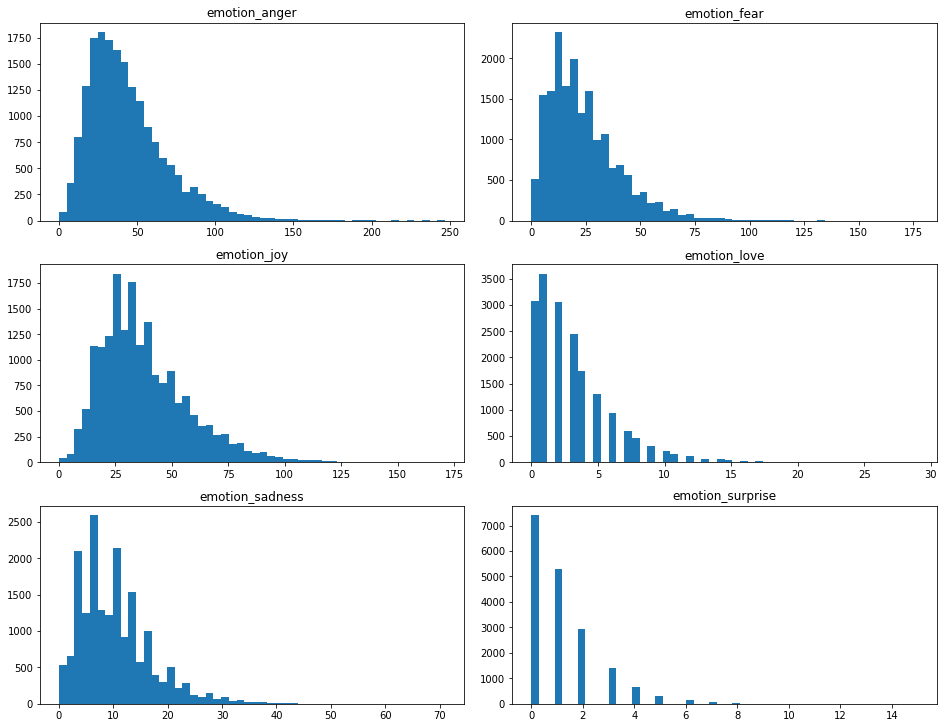

In [27]:
# Distribution of new features
my_j = int(len(emotions_cols)/2)
f,ax=plt.subplots(my_j,2, figsize=(13,10), constrained_layout = True)
feat_iter=iter(emotions_cols)
for i in range(my_j):
    for j in range(2):
      try:
        x = next(feat_iter)
        ax[i,j].hist(df[x], bins=50)
        ax[i,j].set_title(x)
      except StopIteration:
          pass

Scatterplot with target

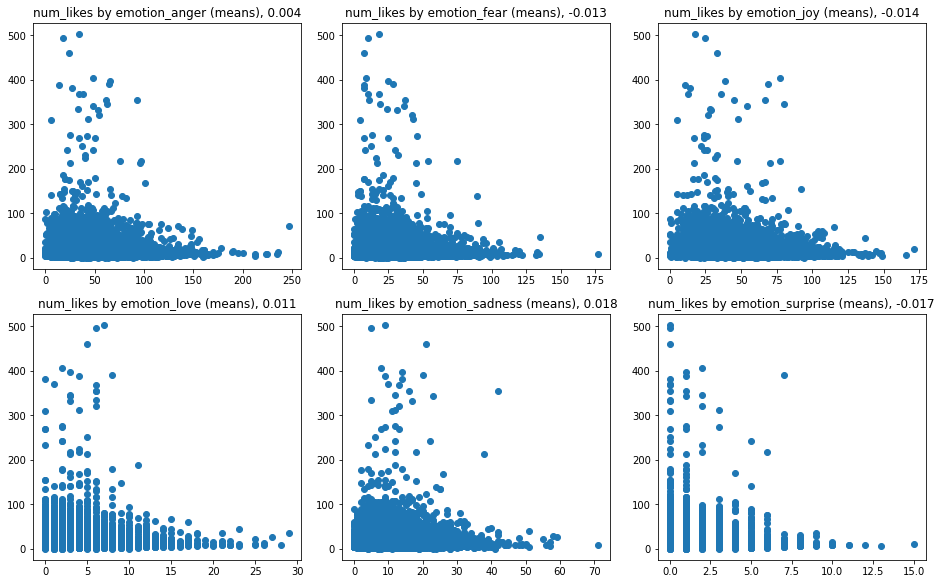

In [26]:
target = 'num_likes'
my_j = int(len(emotions_cols)/3)

f,ax=plt.subplots(my_j,
                  3, 
                  figsize=(13,8), 
                  constrained_layout = True)
feat_iter=iter(emotions_cols)

for i in range(my_j):
    for j in range(3):
      try:
        x = next(feat_iter)
        ax[i,j].scatter(df[x], df[target])
        #df.groupby(x)[target].mean().sort_values().plot.bar(ax=ax[i,j])
        ax[i,j].set_title(f"{target} by {x} (means), {df[x].corr(df[target]):.3f}")
      except StopIteration:
          pass

## Save csv file

In [ ]:
df.to_csv('story_data_new_feats.csv', index=False)